In [21]:
def infer_and_plot_runoff_plain(
    image_paths: list,
    weights_path: str,
    W0: int,
    H0: int,
    extent: tuple,
    T: int = 6,
    hid_ch: int = 8,
    k: int = 3
) -> np.ndarray:
    """
    Même que l’originale, mais sans afficher la colorbar (échelle).
    - image_paths  : liste de vos T PNG
    - weights_path : chemin vers best_qs_only.pth ou model_final_qs_only.pth
    - W0, H0       : largeur, hauteur d’entrée du modèle
    - extent       : (xmin, xmax, ymin, ymax) pour imshow
    - T, hid_ch,k  : hyper-params
    Retourne pred_norm (shape H0×W0).
    """
    import os, sys
    import torch
    import numpy as np
    from PIL import Image
    import matplotlib.pyplot as plt
    from matplotlib.colors import LinearSegmentedColormap

    # 1) importer model.py depuis le dossier des weights
    code_dir = os.path.dirname(os.path.abspath(weights_path))
    sys.path.insert(0, code_dir)
    from model import ConvLSTMForecaster

    # 2) charger le modèle
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model  = ConvLSTMForecaster(in_ch=1, hid_ch=hid_ch, k=k, T=T).to(device).eval()
    state  = torch.load(weights_path, map_location=device, weights_only=True)
    model.load_state_dict(state)

    # 3) préparer les images
    X_list = []
    for p in image_paths:
        im = Image.open(p).convert('L').resize((W0, H0), Image.BILINEAR)
        arr = np.array(im, dtype=np.float32) / 255.0
        X_list.append(arr)
    X = np.stack(X_list).reshape(T, 1, H0, W0)
    Xb = torch.tensor(X).unsqueeze(0).to(device)

    # 4) inférence
    with torch.no_grad():
        pred_norm = model(Xb).cpu().squeeze().numpy()

    # 5) affichage sans colorbar
    data = np.flipud(pred_norm)
    plt.style.use('default')
    fig, ax = plt.subplots(figsize=(10,6), facecolor='white')
    cmap = LinearSegmentedColormap.from_list('dark_blue',['#000033','#ffffff'])
    ax.imshow(
        data,
        origin='lower',
        extent=extent,
        vmin=0, vmax=1,
        cmap=cmap,
        aspect='auto'
    )
    ax.set(
        xlabel='Longitude',
        ylabel='Latitude',
        title=f'Predicted Surface Runoff at T+{T} days (normalized)'
    )
    plt.tight_layout()
    plt.show()

    return pred_norm


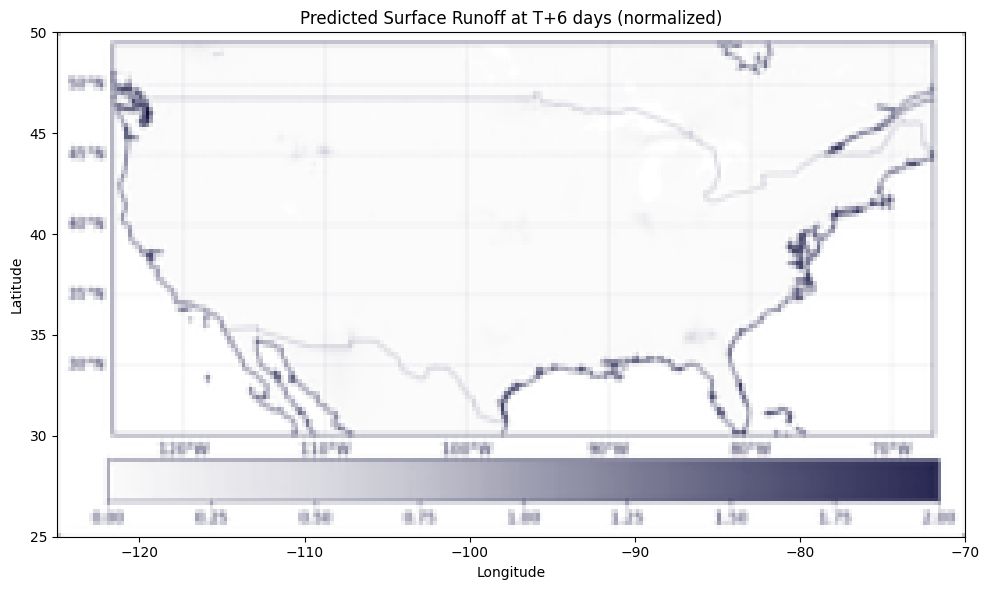

In [22]:
import os

ROOT = '/kaggle/input/data-test'
imgs = [os.path.join(ROOT, f"A1984062{d}.png") for d in range(2,8)]
pth  = os.path.join(ROOT, 'best_qs_only.pth')

predicted_map = infer_and_plot_runoff_plain(
    image_paths  = imgs,
    weights_path = pth,
    W0           = 256,
    H0           = 128,
    extent       = (-125, -70, 25, 50),
    T            = 6,
    hid_ch       = 8,
    k            = 3
)
